# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio_df = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile_df = pd.read_json('data/profile.json', orient='records', lines=True)
transcript_df = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# 1. Checking the shape and datatypes of each dataframe
shapes_and_dtypes = {
    "portfolio": {
        "shape": portfolio_df.shape,
        "dtypes": portfolio_df.dtypes
    },
    "profile": {
        "shape": profile_df.shape,
        "dtypes": profile_df.dtypes
    },
    "transcript": {
        "shape": transcript_df.shape,
        "dtypes": transcript_df.dtypes
    }
}

# 2. Checking for missing values
missing_values = {
    "portfolio": portfolio_df.isnull().sum(),
    "profile": profile_df.isnull().sum(),
    "transcript": transcript_df.isnull().sum()
}

# 3. Describing the basic statistics for numerical columns
descriptive_stats = {
    "portfolio": portfolio_df.describe(),
    "profile": profile_df.describe(),
    "transcript": transcript_df[["time"]].describe()  # Only the "time" column is numerical in the transcript dataset
}

shapes_and_dtypes, missing_values, descriptive_stats

({'portfolio': {'shape': (10, 6), 'dtypes': channels      object
   difficulty     int64
   duration       int64
   id            object
   offer_type    object
   reward         int64
   dtype: object},
  'profile': {'shape': (17000, 5), 'dtypes': age                   int64
   became_member_on      int64
   gender               object
   id                   object
   income              float64
   dtype: object},
  'transcript': {'shape': (306534, 4), 'dtypes': event     object
   person    object
   time       int64
   value     object
   dtype: object}},
 {'portfolio': channels      0
  difficulty    0
  duration      0
  id            0
  offer_type    0
  reward        0
  dtype: int64, 'profile': age                    0
  became_member_on       0
  gender              2175
  id                     0
  income              2175
  dtype: int64, 'transcript': event     0
  person    0
  time      0
  value     0
  dtype: int64},
 {'portfolio':        difficulty   duration     rewa

Let's summarize our data exploration findings:

Portfolio DataFrame (Offers Data)
- Shape: 10 rows, 6 columns.
- Data Types: Mixed (int, float, and object).
- Missing Values: None.

Profile DataFrame (Customer Data)
- Shape: 17,000 rows, 5 columns.
- Data Types: Mixed (int, float, and object).
- Missing Values:
    - gender has 2,175 missing values.
    - income has 2,175 missing values.

Transcript DataFrame (Transaction Data)
- Shape: 306,534 rows, 4 columns.
- Data Types: Mostly object with one int column (time).
- Missing Values: None.
    
    
Descriptive Statistics:
- Portfolio: The offers have varying difficulty levels, rewards, and durations.
- Profile: The age of customers ranges from 18 to 118, with a mean of around 62.5 years (118 might indicate missing value). The income ranges from 30,000 to 120,000, with a mean income of approximately 65,404.
- Transcript: The time variable represents hours since the start of the test and ranges from 0 to 714 hours.

With this understanding, let's move on to Data Visualization to further explore and understand the relationships between variables. We'll start by visualizing the distributions of key variables like age, income, and offer types.

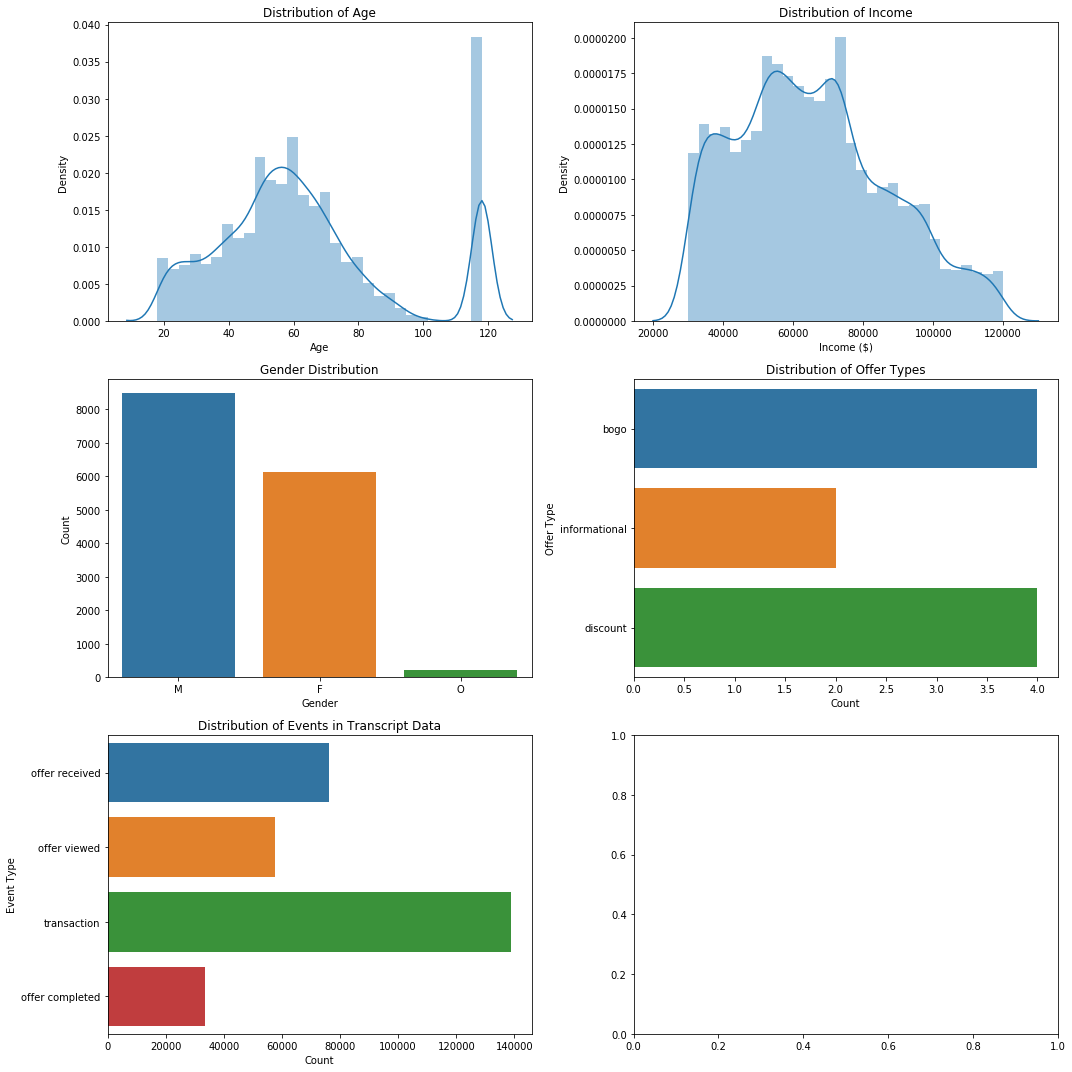

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for different visualizations using alternative plotting methods
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Plotting distributions for the profile data using alternative methods
sns.distplot(profile_df['age'], bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Age')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Density')

sns.distplot(profile_df[profile_df['income'].notnull()]['income'], bins=30, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Income')
axes[0, 1].set_xlabel('Income ($)')
axes[0, 1].set_ylabel('Density')

sns.countplot(data=profile_df, x='gender', ax=axes[1, 0], order=profile_df['gender'].value_counts().index)
axes[1, 0].set_title('Gender Distribution')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Count')

# Plotting distributions for the portfolio data
sns.countplot(data=portfolio_df, y='offer_type', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Offer Types')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Offer Type')

sns.countplot(data=transcript_df, y='event', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Events in Transcript Data')
axes[2, 0].set_xlabel('Count')
axes[2, 0].set_ylabel('Event Type')

# Adjusting the layout
plt.tight_layout()
plt.show()

Profile DataFrame (Customer Data)
- Age Distribution: The age distribution is right-skewed with a prominent spike around the age of 118, potentially indicating outliers or placeholder values.
- Income Distribution: Most customers have an income between 50,000 to 75,000, with the distribution showing a slight right skew.
- Gender Distribution: A majority of the customers identify as male, followed by female, and a small proportion identifies as 'other'.

Portfolio DataFrame (Offers Data)
- Offer Type Distribution: The dataset contains three types of offers: BOGO, discount, and informational. The distribution among these types is nearly even.

Transcript DataFrame (Transaction Data)
- Event Distribution: Most events in the transcript data are transactions, followed by offer received, offer viewed, and offer completed.

Let's proceed with the Data Preprocessing step.
- Handling Missing Values:
    - For the profile dataframe, the columns gender and income have missing values. We need to decide on a strategy to handle these, such as imputation or removal.
- Handling Outliers:
    - The age column in the profile dataframe has a spike at 118, which may represent a placeholder or outlier value. We need to investigate and handle these values.
- Encoding Categorical Variables:
    - The portfolio dataframe contains categorical data in the form of offer_type and channels. These need to be encoded into numerical format for machine learning purposes.
    - Similarly, the transcript dataframe contains categorical data in the event column.
- Feature Engineering:
    - We might need to derive new features or transform existing ones to make the data more suited for modeling.

Let's start with Handling Missing Values in the profile dataframe.

In [4]:
# Handling Missing Values

# Investigate the rows with missing gender and income values
missing_gender_income = profile_df[profile_df['gender'].isnull() & profile_df['income'].isnull()]

# Check if the age of these rows is the suspicious value of 118
suspicious_age = missing_gender_income['age'].unique()

# Drop the rows with missing gender and income values
profile_cleaned = profile_df.dropna(subset=['gender', 'income'])

suspicious_age, profile_df.shape, profile_cleaned.shape

(array([118]), (17000, 5), (14825, 5))

Handling Missing Values - Observations:
- The rows with missing gender and income values all have an age of 118, which corroborates our suspicion that this age value might be a placeholder or outlier.
- We had 17,000 entries in the original profile dataframe. After removing rows with missing gender and income values, we are left with 14,825 entries.

Next, we'll handle Encoding Categorical Variables:
- For the portfolio dataframe, we'll encode the offer_type column and the channels list.
- For the transcript dataframe, we'll encode the event column.

Let's start with the portfolio dataframe.

In [5]:
# Encoding offer_type in portfolio dataframe
offer_type_encoded = pd.get_dummies(portfolio_df['offer_type'], prefix='offer')
portfolio_encoded = pd.concat([portfolio_df, offer_type_encoded], axis=1).drop('offer_type', axis=1)

# Encoding channels in portfolio dataframe
# First, we'll convert the channels list into separate binary columns
for channel in ['web', 'email', 'mobile', 'social']:
    portfolio_encoded[channel] = portfolio_encoded['channels'].apply(lambda x: 1 if channel in x else 0)

# Drop the original channels column
portfolio_encoded = portfolio_encoded.drop('channels', axis=1)

# Encoding event in transcript dataframe
event_encoded = pd.get_dummies(transcript_df['event'], prefix='event')
transcript_encoded = pd.concat([transcript_df, event_encoded], axis=1).drop('event', axis=1)

portfolio_encoded.head()

,difficulty,duration,id,reward,offer_bogo,offer_discount,offer_informational,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,1,0,0


In [6]:
transcript_encoded.head()

,person,time,value,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


We've successfully encoded the categorical variables:

Portfolio DataFrame (Offers Data)
- Encoded the offer_type column into separate binary columns for each offer type.
- Encoded the channels list into separate binary columns for each channel.

Transcript DataFrame (Transaction Data)
- Encoded the event column into separate binary columns for each event type.

Next, we'll address Feature Engineering:
- In the profile dataframe, the became_member_on column represents the date when the customer created an app account. We can convert this into a "membership duration" feature by calculating how long each customer has been a member up to the latest date in the dataset.
- In the transcript dataframe, the value column contains a dictionary with either an offer id or a transaction amount. We can separate these into two distinct columns: offer_id and amount.

Let's proceed with these transformations.

In [7]:
# Feature Engineering

# 1. Convert became_member_on in profile dataframe to membership duration
latest_date = pd.to_datetime(profile_cleaned['became_member_on'], format='%Y%m%d').max()
profile_cleaned['membership_duration'] = (latest_date - pd.to_datetime(profile_cleaned['became_member_on'], format='%Y%m%d')).dt.days
profile_cleaned = profile_cleaned.drop('became_member_on', axis=1)

# 2. Separate the value column in transcript dataframe into offer_id and amount columns
transcript_encoded['offer_id'] = transcript_encoded['value'].apply(lambda x: x.get('offer id') or x.get('offer_id'))
transcript_encoded['amount'] = transcript_encoded['value'].apply(lambda x: x.get('amount', 0))
transcript_encoded = transcript_encoded.drop('value', axis=1)

profile_cleaned.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,age,gender,id,income,membership_duration
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,376
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,91
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,167
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257


In [8]:
transcript_encoded.head()

,person,time,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


The feature engineering steps are now complete:
- In the profile dataframe:
    - The became_member_on column was converted to membership_duration, representing the number of days each customer has been a member.
    - The became_member_on column has been dropped post transformation.
- In the transcript dataframe:
    - The value dictionary column was separated into offer_id and amount columns.
    - The original value column has been dropped post transformation.

Next, let's move on to the Implementation phase. Given the problem statement and the nature of the data, a good starting point would be to predict whether a customer will respond to an offer based on their demographics and the type of offer.

To achieve this, we need to:
- Merge the dataframes to create a unified dataset that links offers, customer demographics, and transaction data.
- Define a target variable to indicate if an offer was successful (i.e., if an offer was completed by a customer).
- Split the data into training and testing sets.
- Train a classifier to predict the success of an offer.

To create a unified dataset:
- We'll merge the portfolio dataframe (offers data) with the transcript dataframe (transaction data) based on the offer_id.
- Next, we'll merge the resulting dataframe with the profile dataframe (customer data) based on the person/id column.

This unified dataset will allow us to link offers, customer demographics, and transaction data together.

In [9]:
# Merge portfolio dataframe with transcript dataframe
merged_df = pd.merge(transcript_encoded, portfolio_encoded, left_on='offer_id', right_on='id', how='left')

# Merge the resulting dataframe with profile dataframe
merged_df = pd.merge(merged_df, profile_cleaned, left_on='person', right_on='id', how='left')

# Drop redundant columns
merged_df = merged_df.drop(columns=['id_x', 'id_y'])

# Display the first few rows of the merged dataframe
merged_df.head()

,person,time,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer_id,amount,difficulty,duration,...,offer_discount,offer_informational,web,email,mobile,social,age,gender,income,membership_duration
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,7.0,...,0.0,0.0,1.0,1.0,1.0,0.0,75.0,F,100000.0,443.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,20.0,10.0,...,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,10.0,7.0,...,1.0,0.0,1.0,1.0,1.0,0.0,68.0,M,70000.0,91.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,10.0,10.0,...,1.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10.0,5.0,...,0.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [10]:
merged_df["event_offer completed"].value_counts()

0    272955
1     33579
Name: event_offer completed, dtype: int64

In [23]:
from sklearn.model_selection import train_test_split

# Splitting data into features and target
X = merged_df.drop(columns=['event_offer completed'])
y = merged_df['event_offer completed']

# Dropping the 'event_offer viewed' and 'event_offer received' columns
X = X.drop(columns=['person', 'offer_id', 'event_offer viewed', 'event_offer received'])

# Splitting the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((245227, 17), (61307, 17))

In [18]:
X_train.isnull().sum()

person                      0
time                        0
event_transaction           0
offer_id               111087
amount                      0
difficulty             111087
duration               111087
reward                 111087
offer_bogo             111087
offer_discount         111087
offer_informational    111087
web                    111087
email                  111087
mobile                 111087
social                 111087
age                     26983
gender                  26983
income                  26983
membership_duration     26983
dtype: int64

In [24]:
# One-hot encoding the 'gender' column
X_train_encoded = pd.get_dummies(X_train, columns=['gender'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['gender'], drop_first=True)

# Ensuring that both training and testing datasets have the same columns
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for c in missing_cols:
    X_test_encoded[c] = 0
X_test_encoded = X_test_encoded[X_train_encoded.columns]

# Filling offer-related columns with zeros
offer_related_columns = ['reward', 'difficulty', 'duration', 'offer_bogo', 'offer_discount', 'offer_informational', 'web', 'email', 'mobile', 'social']
X_train_encoded[offer_related_columns] = X_train_encoded[offer_related_columns].fillna(0)
X_test_encoded[offer_related_columns] = X_test_encoded[offer_related_columns].fillna(0)

# Filling profile-related columns with their respective median values
profile_related_columns = ['age', 'income', 'membership_duration']
for col in profile_related_columns:
    median_value = X_train_encoded[col].median()
    X_train_encoded[col] = X_train_encoded[col].fillna(median_value)
    X_test_encoded[col] = X_test_encoded[col].fillna(median_value)

X_train_encoded.isnull().sum()

time                   0
event_transaction      0
amount                 0
difficulty             0
duration               0
reward                 0
offer_bogo             0
offer_discount         0
offer_informational    0
web                    0
email                  0
mobile                 0
social                 0
age                    0
income                 0
membership_duration    0
gender_M               0
gender_O               0
dtype: int64

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Initializing the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Retraining the Decision Tree classifier
dt_classifier.fit(X_train_encoded, y_train)

# Predicting on the testing data
y_pred = dt_classifier.predict(X_test_encoded)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

{
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Confusion Matrix": conf_matrix,
}

{'Accuracy': 0.88477661604710722,
 'Precision': 0.47667342799188639,
 'Recall': 0.45158906134515892,
 'F1-score': 0.46379231820252015,
 'Confusion Matrix': array([[51188,  3354],
        [ 3710,  3055]])}

The model has a decent accuracy, but the precision, recall, and F1-score are still not very high. This suggests that there's room for further improvement, either by tuning the model, trying different algorithms, or further refining the features. We might want to evaluate the model using cross-validation to get a better sense of its likely performance on unseen data.

In [21]:
from sklearn.model_selection import cross_val_score

# Using cross-validation to get a better sense of model's performance
cross_val_accuracy = cross_val_score(dt_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy').mean()
cross_val_precision = cross_val_score(dt_classifier, X_train_encoded, y_train, cv=5, scoring='precision').mean()
cross_val_recall = cross_val_score(dt_classifier, X_train_encoded, y_train, cv=5, scoring='recall').mean()
cross_val_f1 = cross_val_score(dt_classifier, X_train_encoded, y_train, cv=5, scoring='f1').mean()

{
    "Cross-validated Accuracy": cross_val_accuracy,
    "Cross-validated Precision": cross_val_precision,
    "Cross-validated Recall": cross_val_recall,
    "Cross-validated F1": cross_val_f1
}

{'Cross-validated Accuracy': 0.8859954085865166,
 'Cross-validated Precision': 0.47786596614430971,
 'Cross-validated Recall': 0.46080331457275986,
 'Cross-validated F1': 0.46914680174200896}

The cross-validated metrics are consistent with the performance observed on the single test split, indicating a stable performance of the model across different training subsets.

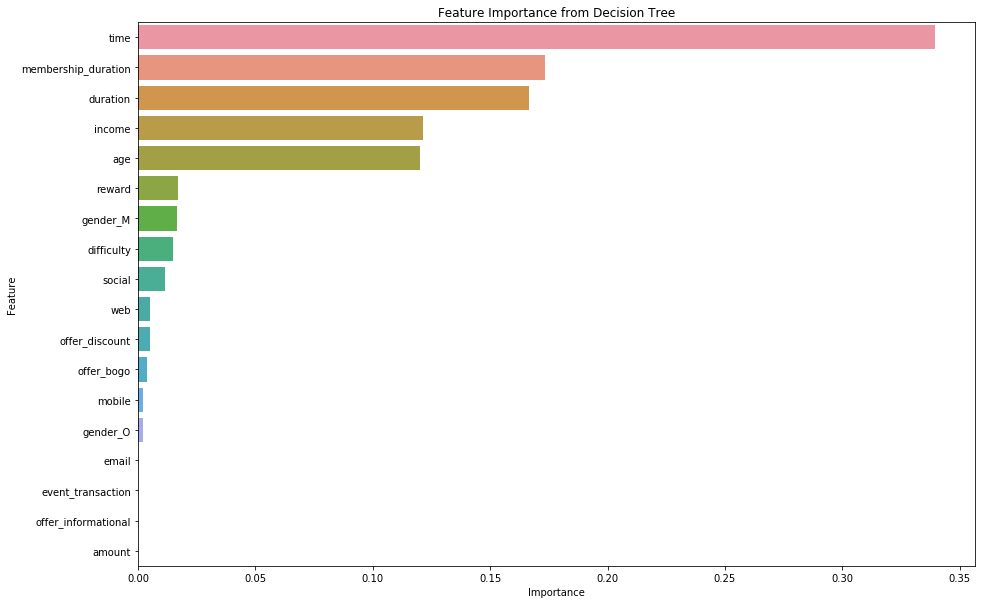

In [22]:
# Extracting feature importance
feature_importance = dt_classifier.feature_importances_

# Creating a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': feature_importance
})

# Sorting the features based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

- The time feature appears to be the most important, followed by membership_duration, income, and age.
- Features like gender_O (indicating "Other" gender) and offer_informational have the least importance in the model's decision-making process.

In [30]:
libraries = {
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'matplotlib': matplotlib.__version__,
    'seaborn': seaborn.__version__,
    'scikit-learn': sklearn.__version__
}

print(libraries)

{'pandas': '0.23.3', 'numpy': '1.12.1', 'matplotlib': '2.1.0', 'seaborn': '0.8.1', 'scikit-learn': '0.19.1'}
